In [22]:
"""
New features introduced in this demo:
- obj = galsim.Gaussian(flux, sigma)
- obj = galsim.Convolve([list of objects])
- image = obj.drawImage(scale)
- image.added_flux  (Only present after a drawImage command.)
- noise = galsim.GaussianNoise(sigma)
- image.addNoise(noise)
- image.write(file_name)
- image.FindAdaptiveMom()
"""

import sys
import os
import math
import numpy
import logging
import time
import galsim

import matplotlib.pyplot as plt
%matplotlib inline

# demo 1

Demo #1

This is the first script in our tutorial about using GalSim in python scripts: examples/demo*.py.
(This file is designed to be viewed in a window 100 characters wide.)
Each of these demo*.py files are designed to be equivalent to the corresponding demo*.yaml file
(or demo*.json -- found in the json directory).  If you are new to python, you should probably
look at those files first as they will probably have a quicker learning curve for you.  Then you
can look through these python scripts, which show how to do the same thing.  Of course, experienced
pythonistas may prefer to start with these scripts and then look at the corresponding YAML files.
To run this script, simply write:
    python demo1.py
This first script is about as simple as it gets.  We draw an image of a single galaxy convolved
with a PSF and write it to disk.  We use a circular Gaussian profile for both the PSF and the
galaxy, and add a constant level of Gaussian noise to the image.
In each demo, we list the new features introduced in that demo file.  These will differ somewhat
between the .py and .yaml (or .json) versions, since the two methods implement things in different
ways.  (demo*.py are python scripts, while demo*.yaml and demo*.json are configuration files.)
New features introduced in this demo:
- obj = galsim.Gaussian(flux, sigma)
- obj = galsim.Convolve([list of objects])
- image = obj.drawImage(scale)
- image.added_flux  (Only present after a drawImage command.)
- noise = galsim.GaussianNoise(sigma)
- image.addNoise(noise)
- image.write(file_name)
- image.FindAdaptiveMom()

In [2]:
"""
About as simple as it gets:
  - Use a circular Gaussian profile for the galaxy.
  - Convolve it by a circular Gaussian PSF.
  - Add Gaussian noise to the image.
"""
# In non-script code, use getLogger(__name__) at module scope instead.
logging.basicConfig(format="%(message)s", level=logging.INFO, stream=sys.stdout)
logger = logging.getLogger("demo1")

gal_flux = 1.e5    # total counts on the image
gal_sigma = 2.     # arcsec
psf_sigma = 1.     # arcsec
pixel_scale = 0.2  # arcsec / pixel
noise = 30.        # standard deviation of the counts in each pixel

logger.info('Starting demo script 1 using:')
logger.info('    - circular Gaussian galaxy (flux = %.1e, sigma = %.1f),',gal_flux,gal_sigma)
logger.info('    - circular Gaussian PSF (sigma = %.1f),',psf_sigma)
logger.info('    - pixel scale = %.2f,',pixel_scale)
logger.info('    - Gaussian noise (sigma = %.2f).',noise)

# Define the galaxy profile
gal = galsim.Gaussian(flux=gal_flux, sigma=gal_sigma)
logger.debug('Made galaxy profile')

# Define the PSF profile
psf = galsim.Gaussian(flux=1., sigma=psf_sigma) # PSF flux should always = 1
logger.debug('Made PSF profile')

# Final profile is the convolution of these
# Can include any number of things in the list, all of which are convolved
# together to make the final flux profile.
final = galsim.Convolve([gal, psf])
logger.debug('Convolved components into final profile')

# Draw the image with a particular pixel scale, given in arcsec/pixel.
# The returned image has a member, added_flux, which is gives the total flux actually added to
# the image.  One could use this value to check if the image is large enough for some desired
# accuracy level.  Here, we just ignore it.
image = final.drawImage(scale=pixel_scale)
logger.debug('Made image of the profile: flux = %f, added_flux = %f',gal_flux,image.added_flux)

# Add Gaussian noise to the image with specified sigma
image.addNoise(galsim.GaussianNoise(sigma=noise))
logger.debug('Added Gaussian noise')

# Write the image to a file
if not os.path.isdir('output'):
    os.mkdir('output')
file_name = os.path.join('output','demo1.fits')
# Note: if the file already exists, this will overwrite it.
image.write(file_name)
logger.info('Wrote image to %r' % file_name)  # using %r adds quotes around filename for us

results = image.FindAdaptiveMom()

logger.info('HSM reports that the image has observed shape and size:')
logger.info('    e1 = %.3f, e2 = %.3f, sigma = %.3f (pixels)', results.observed_shape.e1,
            results.observed_shape.e2, results.moments_sigma)
logger.info('Expected values in the limit that pixel response and noise are negligible:')
logger.info('    e1 = %.3f, e2 = %.3f, sigma = %.3f', 0.0, 0.0,
            math.sqrt(gal_sigma**2 + psf_sigma**2)/pixel_scale)

Starting demo script 1 using:
    - circular Gaussian galaxy (flux = 1.0e+05, sigma = 2.0),
    - circular Gaussian PSF (sigma = 1.0),
    - pixel scale = 0.20,
    - Gaussian noise (sigma = 30.00).
Wrote image to 'output/demo1.fits'
HSM reports that the image has observed shape and size:
    e1 = -0.027, e2 = 0.006, sigma = 11.277 (pixels)
Expected values in the limit that pixel response and noise are negligible:
    e1 = 0.000, e2 = 0.000, sigma = 11.180


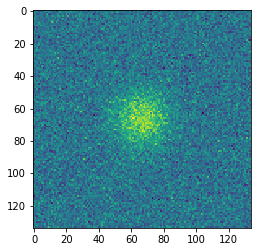

In [7]:
plt.imshow(image.array)

# demo 2


Demo #2
The second script in our tutorial about using GalSim in python scripts: examples/demo*.py.
(This file is designed to be viewed in a window 100 characters wide.)
This script is a bit more sophisticated, but still pretty basic.  We're still only making
a single image, but now the galaxy has an exponential radial profile and is sheared.
The PSF is a circular Moffat profile.  The noise is drawn from a Poisson distribution
using the flux from both the object and a background sky level to determine the
variance in each pixel.
New features introduced in this demo:
- obj = galsim.Exponential(flux, scale_radius)
- obj = galsim.Moffat(beta, flux, half_light_radius)
- obj = obj.shear(g1, g2)  -- with explanation of other ways to specify shear
- rng = galsim.BaseDeviate(seed)
- noise = galsim.PoissonNoise(rng, sky_level)
- galsim.hsm.EstimateShear(image, image_epsf)

In [14]:
"""
A little bit more sophisticated, but still pretty basic:
  - Use a sheared, exponential profile for the galaxy.
  - Convolve it by a circular Moffat PSF.
  - Add Poisson noise to the image.
"""
# In non-script code, use getLogger(__name__) at module scope instead.
logging.basicConfig(format="%(message)s", level=logging.INFO, stream=sys.stdout)
logger = logging.getLogger("demo2")

gal_flux = 1.e5    # counts
gal_r0 = 2.7       # arcsec
g1 = 0.1           #
g2 = 0.3           #
psf_beta = 5       #
psf_re = 1.0       # arcsec
pixel_scale = 0.2  # arcsec / pixel
sky_level = 2.5e3  # counts / arcsec^2

# This time use a particular seed, so the image is deterministic.
# This is the same seed that is used in demo2.yaml, which means the images produced
# by the two methods will be precisely identical.
random_seed = 1534225


logger.info('Starting demo script 2 using:')
logger.info('    - sheared (%.2f,%.2f) exponential galaxy (flux = %.1e, scale radius = %.2f),',
            g1, g2, gal_flux, gal_r0)
logger.info('    - circular Moffat PSF (beta = %.1f, re = %.2f),', psf_beta, psf_re)
logger.info('    - pixel scale = %.2f,', pixel_scale)
logger.info('    - Poisson noise (sky level = %.1e).', sky_level)

# Initialize the (pseudo-)random number generator that we will be using below.
# For a technical reason that will be explained later (demo9.py), we add 1 to the
# given random seed here.
rng = galsim.BaseDeviate(random_seed+1)

# Define the galaxy profile.
gal = galsim.Exponential(flux=gal_flux, scale_radius=gal_r0)

# Shear the galaxy by some value.
# There are quite a few ways you can use to specify a shape.
# q, beta      Axis ratio and position angle: q = b/a, 0 < q < 1
# e, beta      Ellipticity and position angle: |e| = (1-q^2)/(1+q^2)
# g, beta      ("Reduced") Shear and position angle: |g| = (1-q)/(1+q)
# eta, beta    Conformal shear and position angle: eta = ln(1/q)
# e1,e2        Ellipticity components: e1 = e cos(2 beta), e2 = e sin(2 beta)
# g1,g2        ("Reduced") shear components: g1 = g cos(2 beta), g2 = g sin(2 beta)
# eta1,eta2    Conformal shear components: eta1 = eta cos(2 beta), eta2 = eta sin(2 beta)
gal = gal.shear(g1=g1, g2=g2)
logger.debug('Made galaxy profile')

# Define the PSF profile.
psf = galsim.Moffat(beta=psf_beta, flux=1., half_light_radius=psf_re)
logger.debug('Made PSF profile')

# Final profile is the convolution of these.
final = galsim.Convolve([gal, psf])
logger.debug('Convolved components into final profile')

# Draw the image with a particular pixel scale.
image = final.drawImage(scale=pixel_scale)
# The "effective PSF" is the PSF as drawn on an image, which includes the convolution
# by the pixel response.  We label it epsf here.
image_epsf = psf.drawImage(scale=pixel_scale)
logger.debug('Made image of the profile')

# To get Poisson noise on the image, we will use a class called PoissonNoise.
# However, we want the noise to correspond to what you would get with a significant
# flux from tke sky.  This is done by telling PoissonNoise to add noise from a
# sky level in addition to the counts currently in the image.
#
# One wrinkle here is that the PoissonNoise class needs the sky level in each pixel,
# while we have a sky_level in counts per arcsec^2.  So we need to convert:
sky_level_pixel = sky_level * pixel_scale**2
noise = galsim.PoissonNoise(rng, sky_level=sky_level_pixel)
image.addNoise(noise)
logger.debug('Added Poisson noise')

# Write the image to a file.
if not os.path.isdir('output'):
    os.mkdir('output')
file_name = os.path.join('output', 'demo2.fits')
file_name_epsf = os.path.join('output','demo2_epsf.fits')
image.write(file_name)
image_epsf.write(file_name_epsf)
logger.info('Wrote image to %r',file_name)
logger.info('Wrote effective PSF image to %r',file_name_epsf)

results = galsim.hsm.EstimateShear(image, image_epsf)

logger.info('HSM reports that the image has observed shape and size:')
logger.info('    e1 = %.3f, e2 = %.3f, sigma = %.3f (pixels)', results.observed_shape.e1,
            results.observed_shape.e2, results.moments_sigma)
logger.info('When carrying out Regaussianization PSF correction, HSM reports distortions')
logger.info('    e1, e2 = %.3f, %.3f',
            results.corrected_e1, results.corrected_e2)
logger.info('Expected values in the limit that noise and non-Gaussianity are negligible:')
exp_shear = galsim.Shear(g1=g1, g2=g2)
logger.info('    g1, g2 = %.3f, %.3f', exp_shear.e1,exp_shear.e2)

Starting demo script 2 using:
    - sheared (0.10,0.30) exponential galaxy (flux = 1.0e+05, scale radius = 2.70),
    - circular Moffat PSF (beta = 5.0, re = 1.00),
    - pixel scale = 0.20,
    - Poisson noise (sky level = 2.5e+03).
Wrote image to 'output/demo2.fits'
Wrote effective PSF image to 'output/demo2_epsf.fits'
HSM reports that the image has observed shape and size:
    e1 = 0.187, e2 = 0.494, sigma = 16.730 (pixels)
When carrying out Regaussianization PSF correction, HSM reports distortions
    e1, e2 = 0.203, 0.536
Expected values in the limit that noise and non-Gaussianity are negligible:
    g1, g2 = 0.182, 0.545


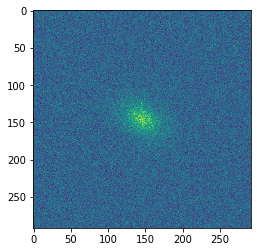

In [12]:
plt.imshow(image.array)

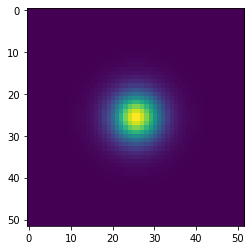

In [15]:
plt.imshow(image_epsf.array)

# demo 3

Demo #3
The third script in our tutorial about using GalSim in python scripts: examples/demo*.py.
(This file is designed to be viewed in a window 100 characters wide.)
This script gets reasonably close to including all the principal features of an image
from a ground-based telescope.  The galaxy is represented as the sum of a bulge and a disk,
where each component is represented by a sheared Sersic profile (with different Sersic
indices).  The PSF has both atmospheric and optical components.  The atmospheric
component is a Kolmogorov turbulent spectrum.  The optical component includes defocus,
coma and astigmatism, as well as obscuration from a secondary mirror.  The noise model
includes both a gain and read noise.  And finally, we include the effect of a slight
telescope distortion.
New features introduced in this demo:
- obj = galsim.Sersic(n, flux, half_light_radius)
- obj = galsim.Sersic(n, flux, scale_radius)
- obj = galsim.Kolmogorov(fwhm)
- obj = galsim.OpticalPSF(lam_over_diam, defocus, coma1, coma2, astig1, astig2, obscuration)
- obj = obj.shear(e, beta)  -- including how to specify an angle in GalSim
- shear = galsim.Shear(q, beta)
- obj = obj.shear(shear)
- obj3 = x1 * obj1 + x2 * obj2
- obj = obj.withFlux(flux)
- image = galsim.ImageF(image_size, image_size)
- image = obj.drawImage(image, wcs)
- image = obj.drawImage(method='sb')
- world_profile = wcs.toWorld(profile)
- shear3 = shear1 + shear2
- noise = galsim.CCDNoise(rng, sky_level, gain, read_noise)

In [16]:
"""
Getting reasonably close to including all the principle features of an image from a
ground-based telescope:
  - Use a bulge plus disk model for the galaxy
  - Both galaxy components are Sersic profiles (n=3.5 and n=1.5 respectively)
  - Let the PSF have both atmospheric and optical components.
  - The atmospheric component is a Kolmogorov spectrum.
  - The optical component has some defocus, coma, and astigmatism.
  - Add both Poisson noise to the image and Gaussian read noise.
  - Let the pixels be slightly distorted relative to the sky.
"""
# We do some fancier logging for demo3, just to demonstrate that we can:
# - we log to both stdout and to a log file
# - the log file has a lot more (mostly redundant) information
logging.basicConfig(format="%(message)s", level=logging.INFO, stream=sys.stdout)
if not os.path.isdir('output'):
    os.mkdir('output')
logFile = logging.FileHandler(os.path.join("output", "script3.log"))
logFile.setFormatter(logging.Formatter("%(name)s[%(levelname)s] %(asctime)s: %(message)s"))
logging.getLogger("demo3").addHandler(logFile)
logger = logging.getLogger("demo3")

gal_flux = 1.e6        # ADU  ("Analog-to-digital units", the units of the numbers on a CCD)
bulge_n = 3.5          #
bulge_re = 2.3         # arcsec
disk_n = 1.5           #
disk_r0 = 0.85         # arcsec (corresponds to half_light_radius of ~3.7 arcsec)
bulge_frac = 0.3       #
gal_q = 0.73           # (axis ratio 0 < q < 1)
gal_beta = 23          # degrees (position angle on the sky)
atmos_fwhm=2.1         # arcsec
atmos_e = 0.13         #
atmos_beta = 0.81      # radians
opt_defocus=0.53       # wavelengths
opt_a1=-0.29           # wavelengths
opt_a2=0.12            # wavelengths
opt_c1=0.64            # wavelengths
opt_c2=-0.33           # wavelengths
opt_obscuration=0.3    # linear scale size of secondary mirror obscuration
lam = 800              # nm    NB: don't use lambda - that's a reserved word.
tel_diam = 4.          # meters
pixel_scale = 0.23     # arcsec / pixel
image_size = 64        # n x n pixels
wcs_g1 = -0.02         #
wcs_g2 = 0.01          #
sky_level = 2.5e4      # ADU / arcsec^2
gain = 1.7             # e- / ADU
                       # Note: here we assume 1 photon -> 1 e-, ignoring QE.  If you wanted,
                       # you could include the QE factor as part of the gain.
read_noise = 0.3       # e- / pixel

random_seed = 1314662

logger.info('Starting demo script 3 using:')
logger.info('    - Galaxy is bulge plus disk, flux = %.1e',gal_flux)
logger.info('       - Bulge is Sersic (n = %.1f, re = %.2f), frac = %.1f',
            bulge_n,bulge_re,bulge_frac)
logger.info('       - Disk is Sersic (n = %.1f, r0 = %.2f), frac = %.1f',
            disk_n,disk_r0,1-bulge_frac)
logger.info('       - Shape is q,beta (%.2f,%.2f deg)', gal_q, gal_beta)
logger.info('    - Atmospheric PSF is Kolmogorov with fwhm = %.2f',atmos_fwhm)
logger.info('       - Shape is e,beta (%.2f,%.2f rad)', atmos_e, atmos_beta)
logger.info('    - Optical PSF has defocus = %.2f, astigmatism = (%.2f,%.2f),',
            opt_defocus, opt_a1, opt_a2)
logger.info('          coma = (%.2f,%.2f), lambda = %.0f nm, D = %.1f m',
            opt_c1, opt_c2, lam, tel_diam)
logger.info('          obscuration linear size = %.1f',opt_obscuration)
logger.info('    - pixel scale = %.2f,',pixel_scale)
logger.info('    - WCS distortion = (%.2f,%.2f),',wcs_g1,wcs_g2)
logger.info('    - Poisson noise (sky level = %.1e, gain = %.1f).',sky_level, gain)
logger.info('    - Gaussian read noise (sigma = %.2f).',read_noise)

# Initialize the (pseudo-)random number generator that we will be using below.
rng = galsim.BaseDeviate(random_seed+1)

# Define the galaxy profile.
# Normally Sersic profiles are specified by half-light radius, the radius that
# encloses half of the total flux.  However, for some purposes, it can be
# preferable to instead specify the scale radius, where the surface brightness
# drops to 1/e of the central peak value.
bulge = galsim.Sersic(bulge_n, half_light_radius=bulge_re)
disk = galsim.Sersic(disk_n, scale_radius=disk_r0)

# Objects may be multiplied by a scalar (which means scaling the flux) and also
# added to each other.
gal = bulge_frac * bulge + (1-bulge_frac) * disk
# Could also have written the following, which does the same thing:
#   gal = galsim.Add([ bulge.withFlux(bulge_frac) , disk.withFlux(1-bulge_frac) ])
# Both syntaxes work with more than two summands as well.

# Set the overall flux of the combined object.
gal = gal.withFlux(gal_flux)
# Since the total flux of the components was 1, we could also have written:
#   gal *= gal_flux
# The withFlux method will always set the flux to the given value, while `gal *= flux`
# will multiply whatever the current flux is by the given factor.

# Set the shape of the galaxy according to axis ratio and position angle
# Note: All angles in GalSim must have explicit units.  Options are:
#       galsim.radians
#       galsim.degrees
#       galsim.arcmin
#       galsim.arcsec
#       galsim.hours
gal_shape = galsim.Shear(q=gal_q, beta=gal_beta*galsim.degrees)
gal = gal.shear(gal_shape)
logger.debug('Made galaxy profile')

# Define the atmospheric part of the PSF.
# Note: the flux here is the default flux=1.
atmos = galsim.Kolmogorov(fwhm=atmos_fwhm)
# For the PSF shape here, we use ellipticity rather than axis ratio.
# And the position angle can be either degrees or radians.  Here we chose radians.
atmos = atmos.shear(e=atmos_e, beta=atmos_beta*galsim.radians)
logger.debug('Made atmospheric PSF profile')

# Define the optical part of the PSF:
# The first argument of OpticalPSF below is lambda/diam (wavelength of light / telescope
# diameter), which needs to be in the same units used to specify the image scale.  We are using
# arcsec for that, so we have to self-consistently use arcsec here, using the following
# calculation:
lam_over_diam = lam * 1.e-9 / tel_diam # radians
lam_over_diam *= 206265  # arcsec
# Note that we could also have made GalSim do the conversion for us if we did not know the right
# factor:
# lam_over_diam = lam * 1.e-9 / tel_diam * galsim.radians
# lam_over_diam = lam_over_diam / galsim.arcsec
logger.debug('Calculated lambda over diam = %f arcsec', lam_over_diam)
# The rest of the values should be given in units of the wavelength of the incident light.
optics = galsim.OpticalPSF(lam_over_diam,
                           defocus = opt_defocus,
                           coma1 = opt_c1, coma2 = opt_c2,
                           astig1 = opt_a1, astig2 = opt_a2,
                           obscuration = opt_obscuration)
logger.debug('Made optical PSF profile')

# So far, our coordinate transformation between image and sky coordinates has been just a
# scaling of the units between pixels and arcsec, which we have defined as the "pixel scale".
# This is fine for many purposes, so we have made it easy to treat the coordinate systems
# this way via the `scale` parameter to commands like drawImage.  However, in general, the
# transformation between the two coordinate systems can be more complicated than that,
# including distortions, rotations, variation in pixel size, and so forth.  GalSim can
# model a number of different "World Coordinate System" (WCS) transformations.  See the
# docstring for BaseWCS for more information.

# In this case, we use a WCS that includes a distortion (specified as g1,g2 in this case),
# which we call a ShearWCS.
wcs = galsim.ShearWCS(scale=pixel_scale, shear=galsim.Shear(g1=wcs_g1, g2=wcs_g2))
logger.debug('Made the WCS')

# Next we will convolve the components in world coordinates.
psf = galsim.Convolve([atmos, optics])
final = galsim.Convolve([psf, gal])
logger.debug('Convolved components into final profile')

# This time we specify a particular size for the image rather than let GalSim
# choose the size automatically.  GalSim has several kinds of images that it can use:
#   ImageF uses 32-bit floats    (like a C float, aka numpy.float32)
#   ImageD uses 64-bit floats    (like a C double, aka numpy.float64)
#   ImageS uses 16-bit integers  (usually like a C short, aka numpy.int16)
#   ImageI uses 32-bit integers  (usually like a C int, aka numpy.int32)
# If you let the GalSim drawImage command create the image for you, it will create an ImageF.
# However, you can make a different type if you prefer.  In this case, we still use
# ImageF, since 32-bit floats are fine.  We just want to set the size explicitly.
image = galsim.ImageF(image_size, image_size)
# Draw the image with the given WCS.  Note that we use wcs rather than scale when the
# WCS is more complicated than just a pixel scale.
final.drawImage(image=image, wcs=wcs)

# Also draw the effective PSF by itself and the optical PSF component alone.
image_epsf = galsim.ImageF(image_size, image_size)
psf.drawImage(image_epsf, wcs=wcs)

# We also draw the optical part of the PSF at its own Nyquist-sampled pixel size
# in order to better see the features of the (highly structured) profile.
# In this case, we draw a "surface brightness image" using method='sb'.  Rather than
# integrate the flux over the area of each pixel, this method just samples the surface
# brightness value at the locations of the pixel centers.  We will encounter a few other
# drawing methods as we go through this sequence of demos.  cf. demos 7, 8, 10, and 11.
image_opticalpsf = optics.drawImage(method='sb')
logger.debug('Made image of the profile')

# This time, we use CCDNoise to model the real noise in a CCD image.  It takes a sky level,
# gain, and read noise, so it can be a bit more realistic than the simpler GaussianNoise
# or PoissonNoise that we used in demos 1 and 2.

# The sky level for CCDNoise is the level per pixel that contributed to the noise.
sky_level_pixel = sky_level * pixel_scale**2

# The gain is in units of e-/ADU.  Technically, one should also account for quantum efficiency
# (QE) of the detector. An ideal CCD has one electron per incident photon, but real CCDs have
# QE less than 1, so not every photon triggers an electron.  We are essentially folding
# the quantum efficiency (and filter transmission and anything else like that) into the gain.
# The read_noise value is given as e-/pixel.  This is modeled as a pure Gaussian noise
# added to the image after applying the pure Poisson noise.
noise = galsim.CCDNoise(rng, gain=gain, read_noise=read_noise, sky_level=sky_level_pixel)
image.addNoise(noise)
logger.debug('Added Gaussian and Poisson noise')

# Write the images to files.
file_name = os.path.join('output', 'demo3.fits')
file_name_epsf = os.path.join('output','demo3_epsf.fits')
file_name_opticalpsf = os.path.join('output','demo3_opticalpsf.fits')
image.write(file_name)
image_epsf.write(file_name_epsf)
image_opticalpsf.write(file_name_opticalpsf)
logger.info('Wrote image to %r', file_name)
logger.info('Wrote effective PSF image to %r', file_name_epsf)
logger.info('Wrote optics-only PSF image (Nyquist sampled) to %r', file_name_opticalpsf)

# Check that the HSM package, which is bundled with GalSim, finds a good estimate
# of the shear.
results = galsim.hsm.EstimateShear(image, image_epsf)

logger.info('HSM reports that the image has observed shape and size:')
logger.info('    e1 = %.3f, e2 = %.3f, sigma = %.3f (pixels)', results.observed_shape.e1,
            results.observed_shape.e2, results.moments_sigma)
logger.info('When carrying out Regaussianization PSF correction, HSM reports')
logger.info('    e1, e2 = %.3f, %.3f',
            results.corrected_e1, results.corrected_e2)
logger.info('Expected values in the limit that noise and non-Gaussianity are negligible:')
# Convention for shear addition is to apply the second term initially followed by the first.
# So this needs to be the WCS shear + the galaxy shape in that order.
total_shape = galsim.Shear(g1=wcs_g1, g2=wcs_g2) + gal_shape
logger.info('    e1, e2 = %.3f, %.3f', total_shape.e1, total_shape.e2)

Starting demo script 3 using:
    - Galaxy is bulge plus disk, flux = 1.0e+06
       - Bulge is Sersic (n = 3.5, re = 2.30), frac = 0.3
       - Disk is Sersic (n = 1.5, r0 = 0.85), frac = 0.7
       - Shape is q,beta (0.73,23.00 deg)
    - Atmospheric PSF is Kolmogorov with fwhm = 2.10
       - Shape is e,beta (0.13,0.81 rad)
    - Optical PSF has defocus = 0.53, astigmatism = (-0.29,0.12),
          coma = (0.64,-0.33), lambda = 800 nm, D = 4.0 m
          obscuration linear size = 0.3
    - pixel scale = 0.23,
    - WCS distortion = (-0.02,0.01),
    - Poisson noise (sky level = 2.5e+04, gain = 1.7).
    - Gaussian read noise (sigma = 0.30).
Wrote image to 'output/demo3.fits'
Wrote effective PSF image to 'output/demo3_epsf.fits'
Wrote optics-only PSF image (Nyquist sampled) to 'output/demo3_opticalpsf.fits'
HSM reports that the image has observed shape and size:
    e1 = 0.099, e2 = 0.193, sigma = 9.282 (pixels)
When carrying out Regaussianization PSF correction, HSM reports
    e1,

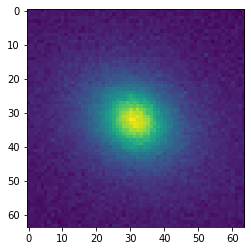

In [18]:
plt.imshow(image.array)

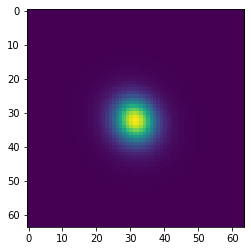

In [19]:
plt.imshow(image_epsf.array)

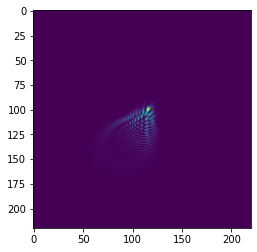

In [21]:
plt.imshow(image_opticalpsf.array)

# demo 4

Demo #4
The fourth script in our tutorial about using GalSim in python scripts: examples/demo*.py.
(This file is designed to be viewed in a window 100 characters wide.)
This script is our first one to create multiple images.  Typically, you would want each object
to have at least some of its attributes vary when you are drawing multiple images (although 
not necessarily -- you might just want different noise realization of the same profile).  
The easiest way to do this is to read in the properties from a catalog, which is what we
do in this script.  The PSF is a truncated Moffat profile, and the galaxy is bulge plus disk,
with knots of star formation modeled as point sources distributed according to a random walk.
Both components get many of their parameters from an input catalog.  We also shift the 
profile by a fraction of a pixel in each direction so the effect of pixelization varies
among the images.  Each galaxy has the same applied shear.  The noise is simple Poisson noise.
We write the images out into a multi-extension fits file.
New features introduced in this demo:
- cat = galsim.Catalog(file_name, dir)
- obj = galsim.Moffat(beta, fwhm, trunc)
- obj = galsim.DeVaucouleurs(flux, half_light_radius=)
- obj = galsim.RandomKnots(npoints, half_light_radius=, flux=)
- obj = galsim.Add([list of objects])
- obj = obj.shift(dx,dy)
- galsim.fits.writeMulti([list of images], file_name)

In [23]:
    """
    Make a fits image cube using parameters from an input catalog
      - The number of images in the cube matches the number of rows in the catalog.
      - Each image size is computed automatically by GalSim based on the Nyquist size.
      - Only galaxies.  No stars.
      - PSF is Moffat
      - Each galaxy is bulge plus disk: deVaucouleurs + Exponential.
      - A fraction of the disk flux is placed into point sources, which can model
        knots of star formation.
      - The catalog's columns are:
         0 PSF beta (Moffat exponent)
         1 PSF FWHM
         2 PSF e1
         3 PSF e2
         4 PSF trunc
         5 Disc half-light-radius
         6 Disc e1
         7 Disc e2
         8 Bulge half-light-radius
         9 Bulge e1
        10 Bulge e2
        11 Galaxy dx (the two components have same center)
        12 Galaxy dy
      - Applied shear is the same for each galaxy
      - Noise is Poisson using a nominal sky value of 1.e6
    """
    logging.basicConfig(format="%(message)s", level=logging.INFO, stream=sys.stdout)
    logger = logging.getLogger("demo4")

    # Define some parameters we'll use below and make directories if needed.
    cat_file_name = os.path.join('input','galsim_default_input.asc')
    if not os.path.isdir('output'):
        os.mkdir('output')
    multi_file_name = os.path.join('output','multi.fits')

    random_seed = 8241573
    sky_level = 1.e6                # ADU / arcsec^2
    pixel_scale = 1.0               # arcsec / pixel  (size units in input catalog are pixels)
    gal_flux = 1.e6                 # arbitrary choice, makes nice (not too) noisy images
    gal_g1 = -0.009                 #
    gal_g2 = 0.011                  #

    # the fraction of flux in each component
    # 40% is in the bulge, 60% in a disk.  70% of that disk light is placed
    # into point sources distributed as a random walk

    bulge_frac       = 0.4
    disk_frac        = 0.6
    knot_frac        = 0.42
    smooth_disk_frac = 0.18

    # number of knots of star formation.  To simulate a nice irregular (all the
    # flux is in knots) we find ~100 is a minimum number needed, but we will
    # just use 10 here to make the demo run fast.

    n_knots = 10

    xsize = 64                      # pixels
    ysize = 64                      # pixels

    logger.info('Starting demo script 4 using:')
    logger.info('    - parameters taken from catalog %r',cat_file_name)
    logger.info('    - Moffat PSF (parameters from catalog)')
    logger.info('    - pixel scale = %.2f',pixel_scale)
    logger.info('    - Bulge + Disc galaxies (parameters from catalog)')
    logger.info('    - 100 Point sources, distributed as random walk')
    logger.info('    - Applied gravitational shear = (%.3f,%.3f)',gal_g1,gal_g2)
    logger.info('    - Poisson noise (sky level = %.1e).', sky_level)

    # Read in the input catalog
    cat = galsim.Catalog(cat_file_name)


    # save a list of the galaxy images in the "images" list variable:
    images = []
    for k in range(cat.nobjects):
        # Initialize the (pseudo-)random number generator that we will be using below.
        # Use a different random seed for each object to get different noise realizations.
        # Using sequential random seeds here is safer than it sounds.  We use Mersenne Twister
        # random number generators that are designed to be used with this kind of seeding.
        # However, to be extra safe, we actually initialize one random number generator with this
        # seed, generate and throw away two random values with that, and then use the next value
        # to seed a completely different Mersenne Twister RNG.  The result is that successive
        # RNGs created this way produce very independent random number streams.
        rng = galsim.BaseDeviate(random_seed+k+1)

        # Take the Moffat beta from the first column (called 0) of the input catalog:
        # Note: cat.get(k,col) returns a string.  To get the value as a float, use either
        #       cat.getFloat(k,col) or float(cat.get(k,col))
        beta = cat.getFloat(k,0)
        # A Moffat's size may be either scale_radius, fwhm, or half_light_radius.
        # Here we use fwhm, taking from the catalog as well.
        fwhm = cat.getFloat(k,1)
        # A Moffat profile may be truncated if desired
        # The units for this are expected to be arcsec (or specifically -- whatever units
        # you are using for all the size values as defined by the pixel_scale).
        trunc = cat.getFloat(k,4)
        # Note: You may omit the flux, since the default is flux=1.
        psf = galsim.Moffat(beta=beta, fwhm=fwhm, trunc=trunc)

        # Take the (e1, e2) shape parameters from the catalog as well.
        psf = psf.shear(e1=cat.getFloat(k,2), e2=cat.getFloat(k,3))

        # Galaxy is a bulge + disk(+knots) with parameters taken from the catalog:

        # put some fraction of the disk light into knots of star formation

        disk_hlr = cat.getFloat(k,5)
        disk_e1 = cat.getFloat(k,6)
        disk_e2 = cat.getFloat(k,7)
        bulge_hlr = cat.getFloat(k,8)
        bulge_e1 = cat.getFloat(k,9)
        bulge_e2 = cat.getFloat(k,10)

        smooth_disk = galsim.Exponential(flux=smooth_disk_frac, half_light_radius=disk_hlr)

        knots = galsim.RandomKnots(n_knots, half_light_radius=disk_hlr, flux=knot_frac, rng=rng)

        disk = galsim.Add([smooth_disk, knots])
        disk = disk.shear(e1=disk_e1, e2=disk_e2)

        # the rest of the light goes into the bulge
        bulge = galsim.DeVaucouleurs(flux=bulge_frac, half_light_radius=bulge_hlr)
        bulge = bulge.shear(e1=bulge_e1, e2=bulge_e2)

        # The flux of an Add object is the sum of the component fluxes.
        # Note that in demo3.py, a similar addition was performed by the binary operator "+".
        gal = galsim.Add([disk, bulge])

        # This flux may be overridden by withFlux.  The relative fluxes of the components
        # remains the same, but the total flux is set to gal_flux.
        gal = gal.withFlux(gal_flux)
        gal = gal.shear(g1=gal_g1, g2=gal_g2)

        # The center of the object is normally placed at the center of the postage stamp image.
        # You can change that with shift:
        gal = gal.shift(dx=cat.getFloat(k,11), dy=cat.getFloat(k,12))

        final = galsim.Convolve([psf, gal])

        # Draw the profile
        image = galsim.ImageF(xsize, ysize)
        final.drawImage(image, scale=pixel_scale)

        # Add Poisson noise to the image:
        image.addNoise(galsim.PoissonNoise(rng, sky_level * pixel_scale**2))

        logger.info('Drew image for object at row %d in the input catalog'%k)
   
        # Add the image to our list of images
        images.append(image)
    
    # Now write the images to a multi-extension fits file.  Each image will be in its own HDU.
    galsim.fits.writeMulti(images, multi_file_name)
    logger.info('Images written to multi-extension fits file %r',multi_file_name)

Starting demo script 4 using:
    - parameters taken from catalog 'input/galsim_default_input.asc'
    - Moffat PSF (parameters from catalog)
    - pixel scale = 1.00
    - Bulge + Disc galaxies (parameters from catalog)
    - 100 Point sources, distributed as random walk
    - Applied gravitational shear = (-0.009,0.011)
    - Poisson noise (sky level = 1.0e+06).
Drew image for object at row 0 in the input catalog
Drew image for object at row 1 in the input catalog
Drew image for object at row 2 in the input catalog
Drew image for object at row 3 in the input catalog
Drew image for object at row 4 in the input catalog
Drew image for object at row 5 in the input catalog
Drew image for object at row 6 in the input catalog
Drew image for object at row 7 in the input catalog
Drew image for object at row 8 in the input catalog
Drew image for object at row 9 in the input catalog
Drew image for object at row 10 in the input catalog
Drew image for object at row 11 in the input catalog
Drew im

# demo 5

Demo #5
The fifth script in our tutorial about using GalSim in python scripts: examples/demo*.py.
(This file is designed to be viewed in a window 100 characters wide.)
This script is intended to mimic a Great08 (Bridle, et al, 2010) LowNoise image.
We produce a single image made up of tiles of postage stamps for each individual object.
(We only do 10 x 10 postage stamps rather than 100 x 100 as they did in the interest of time.)
Each postage stamp is 40 x 40 pixels.  One image is all stars.  A second image is all galaxies.
The stars are truncated Moffat profiles.  The galaxies are Exponential profiles.
(Great08 mixed pure bulge and pure disk for its LowNoise run.  We're just doing disks to
make things simpler. However see demo3 for an example of using bulge+disk galaxies.)
The galaxies are oriented randomly, but in 90 degree-rotated pairs to cancel the effect of
shape noise.  The applied shear is the same for each galaxy.
New features introduced in this demo:
- ud = galsim.UniformDeviate(seed)
- gd = galsim.GaussianDeviate(ud, sigma)
- ccdnoise = galsim.CCDNoise(ud)
- image *= scalar
- bounds = galsim.BoundsI(xmin, xmax, ymin, ymax)
- pos = bounds.center
- pos.x, pos.y
- sub_image = image[bounds]
- Build a single large image, and access sub-images within it.
- Set the galaxy size based on the PSF size and a resolution factor.
- Set the object's flux according to a target S/N value.
- Use 90 degree-rotated pairs for the intrinsic galaxy shapes.
- Shift by a random (dx, dy) drawn from a unit circle top hat.

In [24]:
"""
Make images similar to that done for the Great08 challenge:
  - Each fits file is 10 x 10 postage stamps.
    (The real Great08 images are 100x100, but in the interest of making the Demo
     script a bit quicker, we only build 100 stars and 100 galaxies.)
  - Each postage stamp is 40 x 40 pixels.
  - One image is all stars.
  - A second image is all galaxies.
  - Applied shear is the same for each galaxy.
  - Galaxies are oriented randomly, but in pairs to cancel shape noise.
  - Noise is Poisson using a nominal sky value of 1.e6.
  - Galaxies are Exponential profiles.
"""
logging.basicConfig(format="%(message)s", level=logging.INFO, stream=sys.stdout)
logger = logging.getLogger("demo5")

# Define some parameters we'll use below.
# Normally these would be read in from some parameter file.

nx_tiles = 10                   #
ny_tiles = 10                   #
stamp_xsize = 40                #
stamp_ysize = 40                #

random_seed = 6424512           #

pixel_scale = 1.0               # arcsec / pixel
sky_level = 1.e6                # ADU / arcsec^2

# Make output directory if not already present.
if not os.path.isdir('output'):
    os.mkdir('output')
psf_file_name = os.path.join('output','g08_psf.fits')
psf_beta = 3                    #
psf_fwhm = 2.85                 # arcsec (=pixels)
psf_trunc = 2.*psf_fwhm         # arcsec (=pixels)
psf_e1 = -0.019                 #
psf_e2 = -0.007                 #

gal_file_name = os.path.join('output','g08_gal.fits')
gal_signal_to_noise = 200       # Great08 "LowNoise" run
gal_resolution = 0.98           # r_gal / r_psf (use r = half_light_radius)
# Note: Great08 defined their resolution as r_obs / r_psf, using the convolved
#       size rather than the pre-convolved size.
#       Therefore, our r_gal/r_psf = 0.98 approximately corresponds to
#       their r_obs / r_psf = 1.4.

gal_ellip_rms = 0.2             # using "distortion" definition of ellipticity:
                                #   e = (a^2-b^2)/(a^2+b^2), where a and b are the
                                #   semi-major and semi-minor axes, respectively.
gal_ellip_max = 0.6             # Maximum value of e, to avoid getting near e=1.
gal_g1 = 0.013                  # Applied shear, using normal shear definition:
gal_g2 = -0.008                 #   g = (a-b)/(a+b)

shift_radius = 1.0              # arcsec (=pixels)

logger.info('Starting demo script 5 using:')
logger.info('    - image with %d x %d postage stamps',nx_tiles,ny_tiles)
logger.info('    - postage stamps of size %d x %d pixels',stamp_xsize,stamp_ysize)
logger.info('    - Moffat PSF (beta = %.1f, FWHM = %.2f, trunc = %.2f),',
            psf_beta,psf_fwhm,psf_trunc)
logger.info('    - PSF ellip = (%.3f,%.3f)',psf_e1,psf_e2)
logger.info('    - Exponential galaxies')
logger.info('    - Resolution (r_gal / r_psf) = %.2f',gal_resolution)
logger.info('    - Ellipticities have rms = %.1f, max = %.1f',
            gal_ellip_rms, gal_ellip_max)
logger.info('    - Applied gravitational shear = (%.3f,%.3f)',gal_g1,gal_g2)
logger.info('    - Poisson noise (sky level = %.1e).', sky_level)
logger.info('    - Centroid shifts up to = %.2f pixels',shift_radius)


# Define the PSF profile
psf = galsim.Moffat(beta=psf_beta, fwhm=psf_fwhm, trunc=psf_trunc)

# When something can be constructed from multiple sizes, e.g. Moffat, then
# you can get any size out even if it wasn't the way the object was constructed.
# In this case, we extract the half-light radius, even though we built it with fwhm.
# We'll use this later to set the galaxy's half-light radius in terms of a resolution.
psf_re = psf.half_light_radius

psf = psf.shear(e1=psf_e1,e2=psf_e2)
logger.debug('Made PSF profile')

# Define the galaxy profile

# First figure out the size we need from the resolution
gal_re = psf_re * gal_resolution

# Make the galaxy profile starting with flux = 1.
gal = galsim.Exponential(flux=1., half_light_radius=gal_re)
logger.debug('Made galaxy profile')

# This profile is placed with different orientations and noise realizations
# at each postage stamp in the gal image.
gal_image = galsim.ImageF(stamp_xsize * nx_tiles-1 , stamp_ysize * ny_tiles-1,
                          scale=pixel_scale)
psf_image = galsim.ImageF(stamp_xsize * nx_tiles-1 , stamp_ysize * ny_tiles-1,
                          scale=pixel_scale)

shift_radius_sq = shift_radius**2

first_in_pair = True  # Make pairs that are rotated by 90 degrees

k = 0
for iy in range(ny_tiles):
    for ix in range(nx_tiles):
        # The normal procedure for setting random numbers in GalSim is to start a new
        # random number generator for each object using sequential seed values.
        # This sounds weird at first (especially if you were indoctrinated by Numerical
        # Recipes), but for the boost random number generator we use, the "random"
        # number sequences produced from sequential initial seeds are highly uncorrelated.
        #
        # The reason for this procedure is that when we use multiple processes to build
        # our images, we want to make sure that the results are deterministic regardless
        # of the way the objects get parcelled out to the different processes.
        #
        # Of course, this script isn't using multiple processes, so it isn't required here.
        # However, we do it nonetheless in order to get the same results as the config
        # version of this demo script (demo5.yaml).
        ud = galsim.UniformDeviate(random_seed+k+1)

        # Any kind of random number generator can take another RNG as its first
        # argument rather than a seed value.  This makes both objects use the same
        # underlying generator for their pseudo-random values.
        gd = galsim.GaussianDeviate(ud, sigma=gal_ellip_rms)

        # The -1's in the next line are to provide a border of
        # 1 pixel between postage stamps
        b = galsim.BoundsI(ix*stamp_xsize+1 , (ix+1)*stamp_xsize-1,
                           iy*stamp_ysize+1 , (iy+1)*stamp_ysize-1)
        sub_gal_image = gal_image[b]
        sub_psf_image = psf_image[b]

        # Great08 randomized the locations of the two galaxies in each pair,
        # but for simplicity, we just do them in sequential postage stamps.
        if first_in_pair:
            # Use a random orientation:
            beta = ud() * 2. * math.pi * galsim.radians

            # Determine the ellipticity to use for this galaxy.
            ellip = 1
            while (ellip > gal_ellip_max):
                # Don't do `ellip = math.fabs(gd())`
                # Python basically implements this as a macro, so gd() is called twice!
                val = gd()
                ellip = math.fabs(val)

            # Make a new copy of the galaxy with an applied e1/e2-type distortion
            # by specifying the ellipticity and a real-space position angle
            ellip_gal = gal.shear(e=ellip, beta=beta)

            first_in_pair = False
        else:
            # Use the previous ellip_gal profile and rotate it by 90 degrees
            ellip_gal = ellip_gal.rotate(90 * galsim.degrees)

            first_in_pair = True

        # Apply the gravitational reduced shear by specifying g1/g2
        this_gal = ellip_gal.shear(g1=gal_g1, g2=gal_g2)

        # Apply a random shift_radius:
        rsq = 2 * shift_radius_sq
        while (rsq > shift_radius_sq):
            dx = (2*ud()-1) * shift_radius
            dy = (2*ud()-1) * shift_radius
            rsq = dx**2 + dy**2

        this_gal = this_gal.shift(dx,dy)
        # Note that the shifted psf that we create here is purely for the purpose of being able
        # to draw a separate, shifted psf image.  We do not use it when convolving the galaxy
        # with the psf.
        this_psf = psf.shift(dx,dy)

        # Make the final image, convolving with the (unshifted) psf
        final_gal = galsim.Convolve([psf,this_gal])

        # Draw the image
        final_gal.drawImage(sub_gal_image)

        # Now add an appropriate amount of noise to get our desired S/N
        # There are lots of definitions of S/N, but here is the one used by Great08
        # We use a weighted integral of the flux:
        #   S = sum W(x,y) I(x,y) / sum W(x,y)
        #   N^2 = Var(S) = sum W(x,y)^2 Var(I(x,y)) / (sum W(x,y))^2
        # Now we assume that Var(I(x,y)) is constant so
        #   Var(I(x,y)) = noise_var
        # We also assume that we are using a matched filter for W, so W(x,y) = I(x,y).
        # Then a few things cancel and we find that
        # S/N = sqrt( sum I(x,y)^2 / noise_var )
        #
        # The above procedure is encapsulated in the function image.addNoiseSNR which
        # sets the flux appropriately given the variance of the noise model.
        # In our case, noise_var = sky_level_pixel
        sky_level_pixel = sky_level * pixel_scale**2
        noise = galsim.PoissonNoise(ud, sky_level=sky_level_pixel)
        sub_gal_image.addNoiseSNR(noise, gal_signal_to_noise)

        # Draw the PSF image
        # No noise on PSF images.  Just draw it as is.
        this_psf.drawImage(sub_psf_image)

        # For first instance, measure moments
        if ix==0 and iy==0:
            psf_shape = sub_psf_image.FindAdaptiveMom()
            temp_e = psf_shape.observed_shape.e
            if temp_e > 0.0:
                g_to_e = psf_shape.observed_shape.g / temp_e
            else:
                g_to_e = 0.0
            logger.info('Measured best-fit elliptical Gaussian for first PSF image: ')
            logger.info('  g1, g2, sigma = %7.4f, %7.4f, %7.4f (pixels)',
                        g_to_e*psf_shape.observed_shape.e1,
                        g_to_e*psf_shape.observed_shape.e2, psf_shape.moments_sigma)

        x = b.center.x
        y = b.center.y
        logger.info('Galaxy (%d,%d): center = (%.0f,%0.f)  (e,beta) = (%.4f,%.3f)',
                    ix,iy,x,y,ellip,beta/galsim.radians)
        k = k+1

logger.info('Done making images of postage stamps')

# Now write the images to disk.
psf_image.write(psf_file_name)
logger.info('Wrote PSF file %s',psf_file_name)

gal_image.write(gal_file_name)
logger.info('Wrote image to %r',gal_file_name)  # using %r adds quotes around filename for us

Starting demo script 5 using:
    - image with 10 x 10 postage stamps
    - postage stamps of size 40 x 40 pixels
    - Moffat PSF (beta = 3.0, FWHM = 2.85, trunc = 5.70),
    - PSF ellip = (-0.019,-0.007)
    - Exponential galaxies
    - Resolution (r_gal / r_psf) = 0.98
    - Ellipticities have rms = 0.2, max = 0.6
    - Applied gravitational shear = (0.013,-0.008)
    - Poisson noise (sky level = 1.0e+06).
    - Centroid shifts up to = 1.00 pixels
Measured best-fit elliptical Gaussian for first PSF image: 
  g1, g2, sigma = -0.0090, -0.0033,  1.4107 (pixels)
Galaxy (0,0): center = (20,20)  (e,beta) = (0.2696,4.878)
Galaxy (1,0): center = (60,20)  (e,beta) = (0.2696,4.878)
Galaxy (2,0): center = (100,20)  (e,beta) = (0.0147,2.053)
Galaxy (3,0): center = (140,20)  (e,beta) = (0.0147,2.053)
Galaxy (4,0): center = (180,20)  (e,beta) = (0.1135,1.523)
Galaxy (5,0): center = (220,20)  (e,beta) = (0.1135,1.523)
Galaxy (6,0): center = (260,20)  (e,beta) = (0.1132,4.737)
Galaxy (7,0): center 

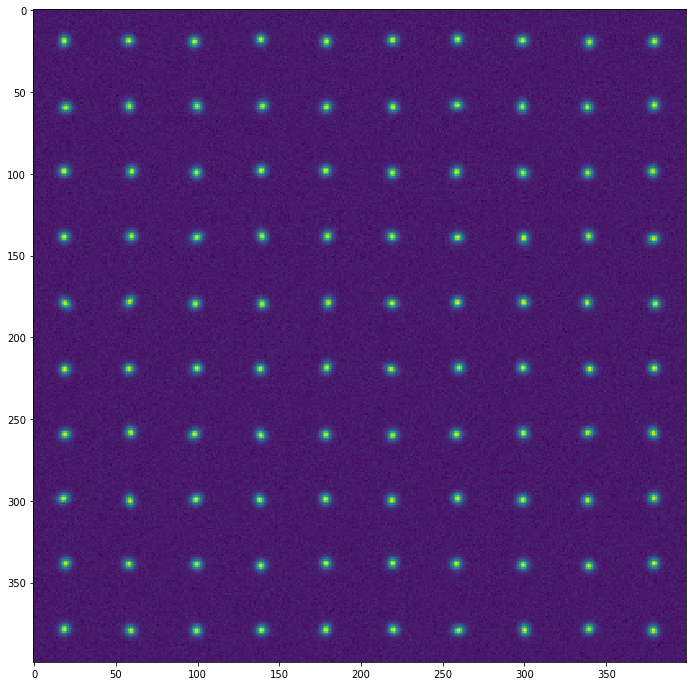

In [27]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
ax.imshow(gal_image.array)

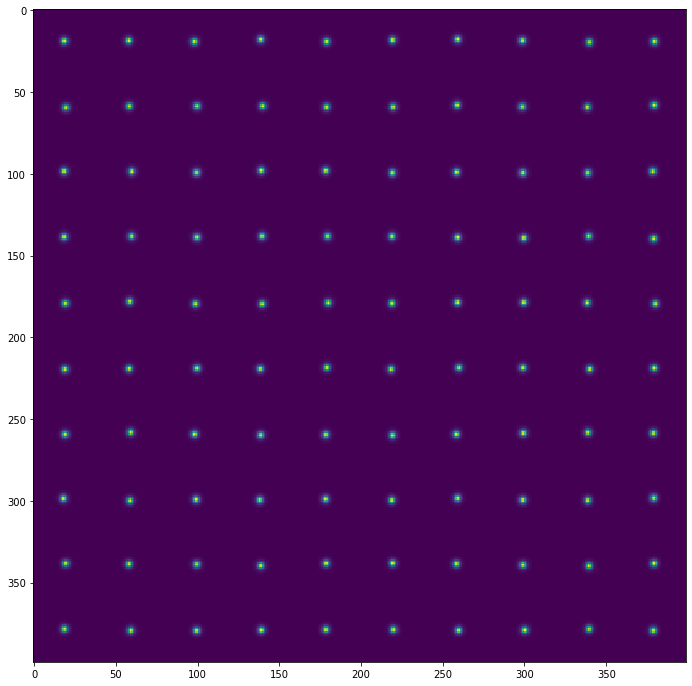

In [29]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
ax.imshow(psf_image.array)